# Clustering Single-cell RNA sequencing data using Autoencoder and Kmeans

The lecture utilises single-cell RNA-seq data from "[scMAE: a masked autoencoder for single-cell RNA-seq clustering](https://doi.org/10.1093/bioinformatics/btae020)". The lecture is divided into the following categories:

1. Learn about raw single-cell data
2. Preprocessing raw data using [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html)
3. Methods
    - Autoencoder
    - KMeans
4. Train model
5. Cluster low-dimensional representation
6. Analyse results

In [147]:
import numpy as np
import pandas as pd
import scanpy as sc
import h5py
import os
import argparse
import warnings
from IPython.core.display import Image, display
warnings.filterwarnings(action='ignore')

## Accessing single-cell data

- Download data from [Zenodo](https://zenodo.org/deposit/8175767)
- These are HDF5 stores containing single-cell gene expression datasets along with their cell types
- Melanoma dataset (Metastatic melanoma)
- Number of cells: 4513, number of genes: 23684, number of cell types: 9
- Dataset from [publication](https://www.weizmann.ac.il/mcb/tirosh/sites/mcb.tirosh/files/uploads/Tirosh_Dissecting_the_melanoma_ecosystem.pdf)
- Cell types: ['B cell', 'CD4+ T cell', 'Endothelial cell', "NK cell", "Tumor", "Unknown", "CAF", "CD8+ T cell", "Macrophage"]

In [148]:
'''import requests
local_data_path = "data/Melanoma_5K.h5"
sc_data_zenodo = "https://zenodo.org/records/8175767/files/Melanoma_5K.h5?download=1"
r = requests.get(sc_data_zenodo, allow_redirects=True)
open(local_data_path, 'wb').write(r.content)'''

'import requests\nlocal_data_path = "data/Melanoma_5K.h5"\nsc_data_zenodo = "https://zenodo.org/records/8175767/files/Macosko.h5?download=1"\nr = requests.get(sc_data_zenodo, allow_redirects=True)\nopen(local_data_path, \'wb\').write(r.content)'

In [149]:
local_data_path = "data/Melanoma_5K.h5" #"data/Limb_Muscle.h5" #"data/Melanoma_5K.h5"
data_mat = h5py.File(local_data_path, "r")
X = np.array(data_mat['X'])
Y = np.array(data_mat['Y'])
print(X.shape, Y.shape)
X[:5]

(4513, 23684) (4513,)


array([[  0., 594.,   0., ...,   0.,   5.,   0.],
       [  0., 330.,   0., ...,   0., 126.,   0.],
       [  0., 635.,   3., ...,  13.,   2.,   0.],
       [  0., 235.,   0., ...,  12.,  27.,   0.],
       [  0., 320.,   0., ...,   2.,  21.,   0.]], dtype=float32)

In [150]:
Y[:5]

array([b'B cell', b'CD8+ T cell', b'Tumor', b'Tumor', b'Tumor'],
      dtype=object)

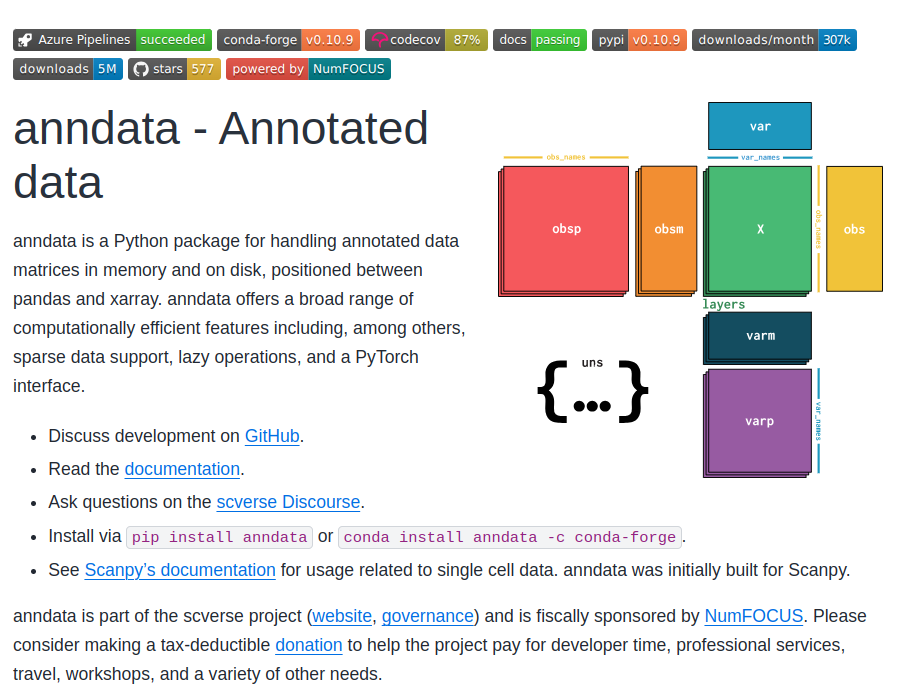

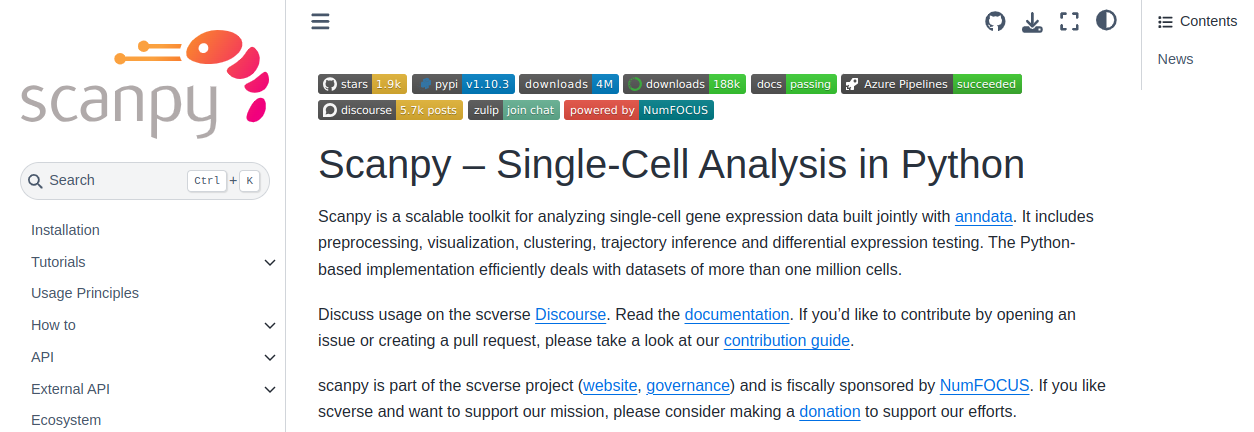

In [151]:
display(Image("figures/anndata.png"))
display(Image("figures/scanpy.png"))

## Data preprocessing

- Data normalisation
- Data imputation

### Data filtering and normalisation

#### AnnData and ScanPy

#### ScanPy

- Filter genes - keep genes that have at least `min_counts` counts - `sc.pp.filter_genes()`
- Filter cells - filter cell outliers based on counts - `sc.pp.filter_cells()`         
- Single-cell RNA sequencing (scRNA-seq) data can vary greatly in sequencing depth across cells, leading to differences in total counts that are not biologically meaningful. Normalization scales the data so that each cell has the same total count to make data from different cells comparable.
- Normalize each cell by total counts over all genes, so every cell has the same total count after normalization. If a cell initially has a total expression count of 50,000 and target_sum=1e4, each gene's counts will be scaled down by a factor of 5 (i.e., 50000/10000 = 5). This ensures that all cells in the dataset have comparable total counts after normalization, facilitating downstream analysis such as clustering or differential expression testing - `scanpy.pp.normalize_total()`
- Highly variable genes - `sc.pp.highly_variable_genes()`

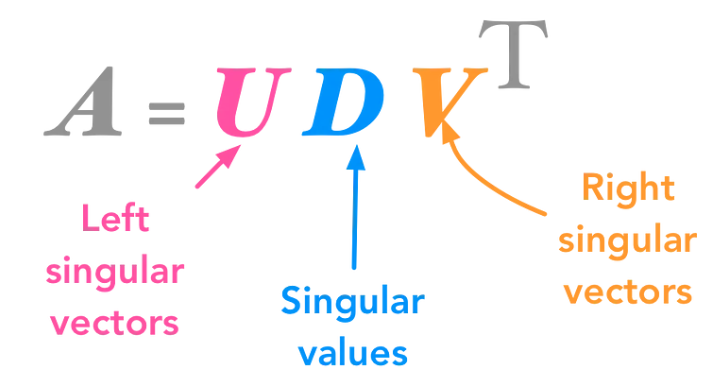

In [152]:
display(Image("figures/svd.png"))

#### Data imputation using TruncatedSVD

- SVD - Singular value decomposition
- Singular values
- U is an m×m orthogonal matrix whose columns are the left singular vectors of A
- D is an m×n diagonal matrix whose diagonal elements are the singular values of A, arranged in descending order
- V.T is an n×n orthogonal matrix whose rows are the right singular vectors of A.
- Properties of SVD
  - Orthogonality: U and V are orthogonal matrices, meaning U.T x U = I and V.T x V = I
  - Singular Values: The diagonal elements of D are non-negative real numbers, called the singular values of A. They indicate the amount of variance captured by each singular vector.

- TruncatedSVD - Take first k columns of U, D(kxk, top k singular values) and first k rows of V.

In [153]:
import os
import scanpy as sc
import h5py
import scipy as sp
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

default_svd_params = {
    "n_components": 128,
    "random_state": 42,
    "n_oversamples": 20,
    "n_iter": 7,
}

encoder_x = LabelEncoder()
celltypes_keys = dict()

class IterativeSVDImputator(object):
    def __init__(self, svd_params=default_svd_params, iters=2):
        self.missing_values = 0.0
        self.svd_params = svd_params
        self.iters = iters
        self.svd_decomposers = [None for _ in range(self.iters)]

    def fit(self, X):
        mask = X == self.missing_values
        transformed_X = X.copy()
        for i in range(self.iters):
            self.svd_decomposers[i] = TruncatedSVD(**self.svd_params)
            self.svd_decomposers[i].fit(transformed_X)
            new_X = self.svd_decomposers[i].inverse_transform(
                self.svd_decomposers[i].transform(transformed_X))
            transformed_X[mask] = new_X[mask]

    def transform(self, X):
        mask = X == self.missing_values
        transformed_X = X.copy()
        for i in range(self.iters):
            new_X = self.svd_decomposers[i].inverse_transform(
                self.svd_decomposers[i].transform(transformed_X))
            transformed_X[mask] = new_X[mask]
            print("if original and transformed same: ", np.all(transformed_X == new_X))
        return transformed_X

In [154]:
def make_dir(directory_path, new_folder_name):
    """Creates an expected directory if it does not exist"""
    directory_path = os.path.join(directory_path, new_folder_name)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    return directory_path

In [155]:
class scRNADataset(Dataset):
    def __init__(self, config, dataset_name, mode='train'):
        """Dataset class for scRNA data format.

        Args:
            config (dict): Dictionary containing options and arguments.
            dataset_name (str): Name of the dataset to load
            mode (bool): Defines whether the data is for Train or Test mode
        """

        self.config = config
        if mode == 'train':
            self.iterator = self.prepare_training_pairs
        else:
            self.iterator = self.prepare_test_pairs
        self.paths = config["paths"]
        self.dataset_name = dataset_name
        self.data_path = os.path.join(self.paths["data"], dataset_name)
        self.data, self.labels = self._load_data()
        self.data_dim = self.data.shape[1]

    def __len__(self):
        """Returns number of samples in the data"""
        return len(self.data)

    def prepare_training_pairs(self, idx):
        sample = self.data[idx]
        sample_tensor = torch.Tensor(sample)
        cluster = int(self.labels[idx])
        return sample, cluster

    def prepare_test_pairs(self, idx):
        sample = self.data[idx]
        cluster = int(self.labels[idx])
        return sample, cluster

    def __getitem__(self, index):
        """Returns batch"""
        return self.iterator(index)

    def _load_data(self):
        """Loads one of many available datasets, and returns features and labels"""

        data, labels = self.load_data(self.data_path)

        n_classes = len(list(set(labels.reshape(-1, ).tolist())))
        self.config["feat_dim"] = data.shape[1]
        if self.config["n_classes"] != n_classes:
            self.config["n_classes"] = n_classes
            print(f"{50 * '>'} Number of classes changed "
                  f"from {self.config['n_classes']} to {n_classes} {50 * '<'}")
        self.data_max = np.max(np.abs(data))
        self.data_min = np.min(np.abs(data))

        return data, labels

    def load_data(self, path):
        """Loads scRNA-seq dataset"""
        data_mat = h5py.File(
            f"{path}.h5", "r")
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        
        # encode labels
        if Y.dtype != "int64":
            Y = encoder_x.fit_transform(Y)
        celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
        print(celltypes_keys)

        # extract genes
        nb_genes = self.config["data_dim"]

        # convert to integers
        X = np.ceil(X).astype(np.int)
        
        count_X = X
        print(f"keeping {nb_genes} genes")

        # convert to AnnData format
        adata = sc.AnnData(X)
        print("Original data")
        print(X[:5], X.shape)
        print("----")

        # normalise
        adata = self.normalize(adata,
                               copy=True,
                               highly_genes=nb_genes,
                               size_factors=True,
                               normalize_input=True,
                               logtrans_input=True)

        # extract top nb_genes genes - highly variable genes
        sorted_genes = adata.var_names[np.argsort(adata.var["mean"])]
        adata = adata[:, sorted_genes]
        X = adata.X.astype(np.float32)
        # impute missing data
        imputator = IterativeSVDImputator(iters=1)
        imputator.fit(X)
        X = imputator.transform(X)
        return X, Y

    def normalize(self, adata, copy=True, highly_genes=None, filter_min_counts=True,
                  size_factors=True, normalize_input=True, logtrans_input=True):
        """
        Normalizes input data and retains only most variable genes
        (indicated by highly_genes parameter)

        Args:
            adata ([type]): [description]
            copy (bool, optional): [description]. Defaults to True.
            highly_genes ([type], optional): [description]. Defaults to None.
            filter_min_counts (bool, optional): [description]. Defaults to True.
            size_factors (bool, optional): [description]. Defaults to True.
            normalize_input (bool, optional): [description]. Defaults to True.
            logtrans_input (bool, optional): [description]. Defaults to True.

        Raises:
            NotImplementedError: [description]

        Returns:
            [type]: [description]
        """
        if isinstance(adata, sc.AnnData):
            if copy:
                adata = adata.copy()
        elif isinstance(adata, str):
            adata = sc.read(adata)
        else:
            raise NotImplementedError
        norm_error = 'Make sure that the dataset (adata.X) contains unnormalized count data.'
        assert 'n_count' not in adata.obs, norm_error
        if adata.X.size < 50e6:  # check if adata.X is integer only if array is small
            if sp.sparse.issparse(adata.X):
                assert (adata.X.astype(int) != adata.X).nnz == 0, norm_error
            else:
                assert np.all(adata.X.astype(int) == adata.X), norm_error

        if filter_min_counts:
            sc.pp.filter_genes(adata, min_counts=1)
            sc.pp.filter_cells(adata, min_counts=1)
        print("After filtering")
        print(adata.X[:5], adata.X.shape)
        print("-------")
        if size_factors or normalize_input or logtrans_input:
            adata.raw = adata.copy()
        else:
            adata.raw = adata
        if size_factors:
            #sc.pp.normalize_per_cell(adata)
            sc.pp.normalize_total(adata, target_sum=1e4)
            print("After normalize_total")
            print(adata.X[:5], adata.X.shape)
            print("-------")
            adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
        else:
            adata.obs['size_factors'] = 1.0
        if logtrans_input:
            sc.pp.log1p(adata)
            print("After log1p transformation")
            print(adata.X[:5], adata.X.shape)
            print("-------")
        if highly_genes != None:
            sc.pp.highly_variable_genes(
                adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=highly_genes, subset=True)
            print("After getting highly_variable_genes")
            print(adata.X[:5], adata.X.shape)
            print("-------")
        if normalize_input:
            sc.pp.scale(adata)
            print("After scaling")
            print(adata.X[:5], adata.X.shape)
            print("-------")
        return adata

In [156]:
class Loader(object):
    """ Data loader """

    def __init__(self, config, dataset_name, drop_last=True, kwargs={}):
        """Pytorch data loader

        Args:
            config (dict): Dictionary containing options and arguments.
            dataset_name (str): Name of the dataset to load
            drop_last (bool): True in training mode, False in evaluation.
            kwargs (dict): Dictionary for additional parameters if needed

        """
        # Get batch size
        batch_size = config["batch_size"]
        # Get config
        self.config = config
        # Get the datasets
        print("Loading train and test datasets")
        train_dataset, test_dataset = self.get_dataset(
            dataset_name)
        self.data_max = train_dataset.data_max
        self.data_min = train_dataset.data_min

        # Set the loader for training set
        self.train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, drop_last=drop_last, **kwargs)
        # Set the loader for test set
        self.test_loader = DataLoader(
            test_dataset, batch_size=batch_size*5, shuffle=False, drop_last=False, **kwargs)

    def get_dataset(self, dataset_name):
        """Returns training, validation, and test datasets"""
        # Create dictionary for loading functions of datasets.
        # If you add a new dataset, add its corresponding dataset class here in the form 'dataset_name': ClassName
        loader_map = {'default_loader': scRNADataset}
        # Get dataset. Check if the dataset has a custom class.
        # If not, then assume a tabular data with labels in the first column
        dataset = loader_map[dataset_name] if dataset_name in loader_map.keys(
        ) else loader_map['default_loader']
        # Training  datasets
        train_dataset = dataset(
            self.config, dataset_name=dataset_name, mode='train')
        # Test dataset
        test_dataset = dataset(
            self.config, dataset_name=dataset_name, mode='test')
        # Return
        return train_dataset, test_dataset

def apply_noise(X, p=[0.2,0.4]):
    p = torch.tensor(p)
    should_swap = torch.bernoulli(p.to(
        X.device) * torch.ones((X.shape)).to(X.device))
    corrupted_X = torch.where(
        should_swap == 1, X[torch.randperm(X.shape[0])], X)
    masked = (corrupted_X != X).float()
    return corrupted_X, masked

In [157]:
args = {}
args["num_workers"] = 4
args["paths"] = {"data": "data/",
                "results": "./res/"}
args['batch_size'] = 256
args["data_dim"] = 1000
args['n_classes'] = 9 #4
args['epochs'] = 80 #80
args["dataset"] = "Smart-seq2"
args["learning_rate"] = 1e-3
args["latent_dim"] = 32 #128
path = args["paths"]["data"]
files = ["Limb_Muscle"]

'''files = ["Pollen", "Quake_Smart-seq2_Lung", "Limb_Muscle", 
         "worm_neuron_cell", "Melanoma_5K", "Young", "Guo", "Baron", 
         "Wang", "Quake_10x_Spleen", "Shekhar", "Macosko", 
         "Tosches", "Bach", "hrvatin"]'''

results = pd.DataFrame()
dataset = files[0]
save_dir = make_dir(args["paths"]["results"], "a_summary")
print(f">> {dataset}")
args["dataset"] = files[0]
args["save_path"] = make_dir("data/sc_data/scMAE/" + str(123), dataset)

data_load = Loader(args, dataset_name=args["dataset"], drop_last=True)

>> Limb_Muscle
Loading train and test datasets
{0: 'B cell', 1: 'T cell', 2: 'endothelial cell', 3: 'macrophage', 4: 'mesenchymal stem cell', 5: 'skeletal muscle satellite cell'}
keeping 1000 genes
Original data
[[0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (3909, 23341)
----
After filtering
[[0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]] (3909, 16512)
-------
After normalize_total
[[0.        4.708098  0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        3.9572616 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        9.099181 ]] (3909, 16512)
-------
After log1p transformation
[[0.        1.7418859 0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       

### scMAE workflow

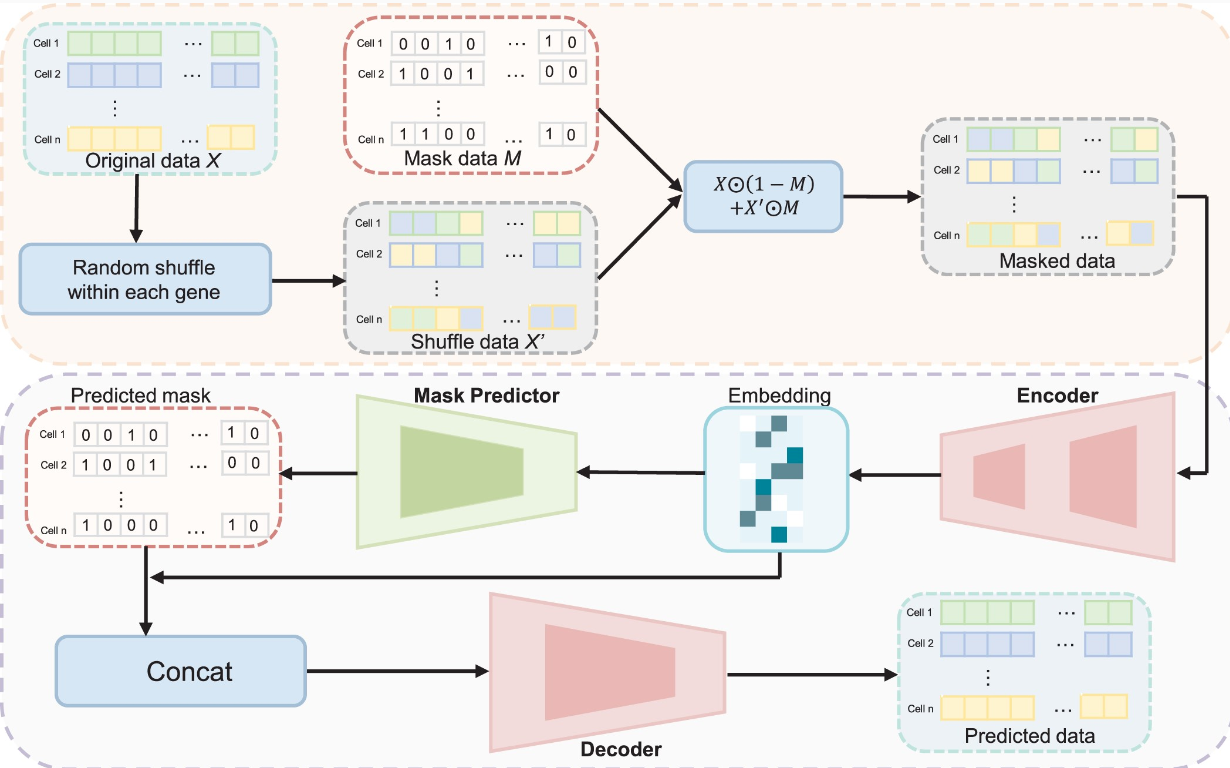

In [158]:
display(Image("figures/scMAE_workflow.png"))

In [159]:
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits as bce_logits
from torch.nn.functional import mse_loss as mse


class AutoEncoder(torch.nn.Module):
    def __init__(
        self,
        num_genes,
        hidden_size=128,
        dropout=0,
        masked_data_weight=.75,
        mask_loss_weight=0.7,
    ):
        super().__init__()
        self.num_genes = num_genes
        self.masked_data_weight = masked_data_weight
        self.mask_loss_weight = mask_loss_weight

        self.encoder = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.num_genes, 256),
            nn.LayerNorm(256),
            # Mish: A Self Regularized Non-Monotonic Neural Activation Function
            nn.Mish(inplace=True),
            nn.Linear(256, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Mish(inplace=True),
            nn.Linear(hidden_size, hidden_size)
        )

        self.mask_predictor = nn.Linear(hidden_size, num_genes)
        self.decoder = nn.Linear(
            in_features=hidden_size+num_genes, out_features=num_genes)

    def forward_mask(self, x):
        # latent representation
        latent = self.encoder(x)
        predicted_mask = self.mask_predictor(latent)
        reconstruction = self.decoder(
            torch.cat([latent, predicted_mask], dim=1))

        return latent, predicted_mask, reconstruction

    def loss_mask(self, x, y, mask):
        latent, predicted_mask, reconstruction = self.forward_mask(x)
        w_nums = mask * self.masked_data_weight + (1 - mask) * (1 - self.masked_data_weight)
        reconstruction_loss = (1-self.mask_loss_weight) * torch.mul(
            w_nums, mse(reconstruction, y, reduction='none'))
        mask_loss = self.mask_loss_weight * \
            bce_logits(predicted_mask, mask, reduction="mean")
        reconstruction_loss = reconstruction_loss.mean()

        loss = reconstruction_loss + mask_loss 
        return latent, loss

    def feature(self, x):
        latent = self.encoder(x)
        return latent


In [160]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [161]:
from __future__ import print_function
import time
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment as hungarian
from sklearn import metrics
from munkres import Munkres


def evaluate(label, pred):
    nmi = metrics.normalized_mutual_info_score(label, pred)
    ari = metrics.adjusted_rand_score(label, pred)
    # f = metrics.fowlkes_mallows_score(label, pred)
    pred_adjusted = get_y_preds(
        label, pred, max(len(set(label)), len(set(pred))))
    acc = metrics.accuracy_score(pred_adjusted, label)
    return nmi, ari, acc


def evaluate_others(label, pred):
    ami = metrics.adjusted_mutual_info_score(label, pred)
    homo, comp, v_mea = metrics.homogeneity_completeness_v_measure(label, pred)
    return ami, homo, comp, v_mea


def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))
    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:, j])  # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i, j]
            cost_matrix[j, i] = s - t
    return cost_matrix


def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    cluster_labels = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_labels[i] = indices[i][1]
    return cluster_labels


def get_y_preds(y_true, cluster_assignments, n_clusters):
    """
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)
    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset
    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    """
    confusion_matrix = metrics.confusion_matrix(
        y_true, cluster_assignments, labels=None
    )
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)

    if np.min(cluster_assignments) != 0:
        cluster_assignments = cluster_assignments - np.min(cluster_assignments)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred


In [170]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import random
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def inference(net, data_loader_test):
    net.eval()
    original_data = []
    feature_vector = []
    labels_vector = []
    with torch.no_grad():
        for step, (x, y) in enumerate(data_loader_test):
            feature_vector.extend(net.feature(x.cuda()).detach().cpu().numpy())
            labels_vector.extend(y.numpy())
            original_data.extend(x.detach().cpu().numpy())
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    original_data = np.array(original_data)
    return feature_vector, labels_vector, original_data


def res_search_fixed_clus(adata, fixed_clus_count, increment=0.02):
    '''
        arg1(adata)[AnnData matrix]
        arg2(fixed_clus_count)[int]

        return:
            resolution[int]
    '''
    dis = []
    resolutions = sorted(list(np.arange(0.01, 2.5, increment)), reverse=True)
    i = 0
    res_new = []
    for res in resolutions:
        sc.tl.leiden(adata, random_state=0, resolution=res)
        count_unique_leiden = len(pd.DataFrame(
            adata.obs['leiden']).leiden.unique())
        dis.append(abs(count_unique_leiden-fixed_clus_count))
        res_new.append(res)
        if count_unique_leiden == fixed_clus_count:
            break
    reso = resolutions[np.argmin(dis)]

    return reso


def plot_umap(pre_data, true_labels, pred_labels):

    n_neighbors=50
    min_dist=0.99
    metric='correlation'
    unique_labels = np.unique(true_labels)
    print("Number of cell types: {}".format(unique_labels))
    print("Data dimensions: {}".format(pre_data.shape))
    cmap = ListedColormap(sns.color_palette("husl", len(unique_labels)))

    embeddings = umap.UMAP(
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric='correlation'
    ).fit_transform(pre_data)

    # Create a DataFrame with UMAP components and true labels
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": true_labels}
    df_pre_sc = pd.DataFrame(data)

    df_pre_sc['Cluster'] = true_labels
    celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
    print(celltypes_keys)
    df_pre_sc['Cell types'] = df_pre_sc['Cluster'].map(celltypes_keys)
    print(df_pre_sc.head())

    #plt.figure(figsize=(8, 6))
    #sns.scatterplot(x="UMAP1", y="UMAP2", hue="Cell types", palette='tab10', data=df_pre_sc, s=5)
    #plt.title("UMAP Visualization data with original dimensions and true labels")
    #plt.show()

    #################
    # Create a DataFrame with UMAP components and pred labels
    data_pred = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": pred_labels}
    df_pre_sc_pred = pd.DataFrame(data_pred)

    df_pre_sc_pred['Cluster'] = pred_labels
    celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
    print(celltypes_keys)
    df_pre_sc_pred['Cell types'] = df_pre_sc_pred['Cluster'].map(celltypes_keys)
    print(df_pre_sc_pred.head())

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Cell types", palette='tab10', data=df_pre_sc_pred, s=5)
    plt.title("UMAP Visualization data with original dimensions and pred labels")
    plt.show()


def plot_true_pred_umap(pre_data, true_labels, pred_labels):

    n_neighbors=50
    min_dist=0.99
    metric='correlation'
    unique_labels = np.unique(true_labels)
    print("Number of cell types: {}".format(unique_labels))
    print("Data dimensions: {}".format(pre_data.shape))
    cmap = ListedColormap(sns.color_palette("husl", len(unique_labels)))

    embeddings = umap.UMAP(
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric='correlation'
    ).fit_transform(pre_data)

    # Create a DataFrame with UMAP components and true labels
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": true_labels}
    df_pre_sc = pd.DataFrame(data)

    df_pre_sc['Cluster'] = true_labels
    celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
    print(celltypes_keys)
    df_pre_sc['Cell types'] = df_pre_sc['Cluster'].map(celltypes_keys)
    print(df_pre_sc.head())

    #plt.figure(figsize=(8, 6))
    #sns.scatterplot(x="UMAP1", y="UMAP2", hue="Cell types", palette='tab10', data=df_pre_sc, s=5)
    #plt.title("UMAP Visualization latent dimensions data and true labels")
    #plt.show()

    #################
    # Create a DataFrame with UMAP components and pred labels
    data_pred = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": pred_labels}
    df_pre_sc_pred = pd.DataFrame(data_pred)

    df_pre_sc_pred['Cluster'] = pred_labels
    celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
    print(celltypes_keys)
    df_pre_sc_pred['Cell types'] = df_pre_sc_pred['Cluster'].map(celltypes_keys)
    print(df_pre_sc_pred.head())

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Cell types", palette='tab10', data=df_pre_sc_pred, s=5)
    plt.title("UMAP Visualization latent dimensions data and pred labels")
    plt.show()


def train(args):
    data_load = Loader(args, dataset_name=args["dataset"], drop_last=True)
    data_loader = data_load.train_loader
    data_loader_test = data_load.test_loader
    x_shape = args["data_dim"]

    results = []

    # Hyper-params
    init_lr = args["learning_rate"]
    max_epochs = args["epochs"]
    mask_probas = [0.4]*x_shape

    # setup model
    model = AutoEncoder(
        num_genes=x_shape,
        hidden_size=args["latent_dim"],
        masked_data_weight=0.75,
        mask_loss_weight=0.7
    ).cuda()
    model_checkpoint = 'model_checkpoint.pth'

    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    # train model
    for epoch in range(max_epochs):
        model.train()
        meter = AverageMeter()
        for i, (x, y) in enumerate(data_loader):
            x = x.cuda()
            x_corrputed, mask = apply_noise(x, mask_probas)
            optimizer.zero_grad()
            x_corrputed_latent, loss_ae = model.loss_mask(x_corrputed, x, mask)
            loss_ae.backward()
            optimizer.step()
            meter.update(loss_ae.detach().cpu().numpy())

        if ((epoch + 1) % 80) == 0:
            print("Evaluating at epoch: {}".format(epoch + 1))
            # Generator in eval mode
            latent, true_label, orig_x = inference(model, data_loader_test)
            
            if latent.shape[0] < 10000:
                clustering_model = KMeans(n_clusters=args["n_classes"])
                clustering_model.fit(latent)
                pred_label = clustering_model.labels_
            else:
                adata = sc.AnnData(latent)
                sc.pp.neighbors(adata, n_neighbors=10, use_rep="X")
                # sc.tl.umap(adata)
                reso = res_search_fixed_clus(adata, args["n_classes"])
                sc.tl.leiden(adata, resolution=reso)
                pred = adata.obs['leiden'].to_list()
                pred_label = [int(x) for x in pred]

            plot_umap(orig_x, true_label, pred_label)
            plot_true_pred_umap(latent, true_label, pred_label)

            nmi, ari, acc = evaluate(true_label, pred_label)
            ss = silhouette_score(latent, pred_label)

            res = {}
            res["nmi"] = nmi
            res["ari"] = ari
            res["acc"] = acc
            res["sil"] = ss
            res["dataset"] = args["dataset"]
            res["epoch"] = epoch
            results.append(res)

            print("\tEvalute: [nmi: %f] [ari: %f] [acc: %f]" % (nmi, ari, acc))

            np.save(args["save_path"]+"/embedding_"+str(epoch)+".npy", 
                    latent)
            pd.DataFrame({"True": true_label, 
                        "Pred": pred_label}).to_csv(args["save_path"]+"/types_"+str(epoch)+".txt")

    torch.save({
        "optimizer": optimizer.state_dict(),
        "model": model.state_dict()
    }, model_checkpoint
    )

    return results


def run_scMAE():
    for i in range(1):
        seed = random.randint(1, 100)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        args = {}
        args["num_workers"] = 4
        args["paths"] = {"data": "data/",
                        "results": "./res/"}
        args['batch_size'] = 256
        args["data_dim"] = 1000
        args['n_classes'] = 9 #6
        args['epochs'] = 80
        args["dataset"] = "Smart-seq2"
        args["learning_rate"] = 1e-3
        args["latent_dim"] = 128 #32 #128

        print(args)

        path = args["paths"]["data"]
        files = ["Melanoma_5K"] #["Melanoma_5K"]
        
        '''files = ["Pollen", "Quake_Smart-seq2_Lung", "Limb_Muscle", 
                 "worm_neuron_cell", "Melanoma_5K", "Young", "Guo", "Baron", 
                 "Wang", "Quake_10x_Spleen", "Shekhar", "Macosko", 
                 "Tosches", "Bach", "hrvatin"]'''

        results = pd.DataFrame()
        save_dir = make_dir(args["paths"]["results"], "a_summary")
        for dataset in files:
            print(f">> {dataset}")
            args["dataset"] = dataset
            args["save_path"] = make_dir("data/sc_data/scMAE/" + str(i), dataset)

            res = train(args)
            print(res)
            results = results.append(res)
            results.to_csv(args["paths"]["results"] +
                        "/res_all_data_test"+str(i)+".csv", header=True)

{'num_workers': 4, 'paths': {'data': 'data/', 'results': './res/'}, 'batch_size': 256, 'data_dim': 1000, 'n_classes': 6, 'epochs': 80, 'dataset': 'Smart-seq2', 'learning_rate': 0.001, 'latent_dim': 128}
>> Melanoma_5K
Loading train and test datasets
{0: 'B cell', 1: 'CAF', 2: 'CD4+ T cell', 3: 'CD8+ T cell', 4: 'Endothelial cell', 5: 'Macrophage', 6: 'NK cell', 7: 'Tumor', 8: 'Unknown'}
keeping 1000 genes
Original data
[[  0 594   0 ...   0   5   0]
 [  0 330   0 ...   0 126   0]
 [  0 635   3 ...  13   2   0]
 [  0 235   0 ...  12  27   0]
 [  0 320   0 ...   2  21   0]] (4513, 23684)
----
After filtering
[[  0 594   0 ...   0   5   0]
 [  0 330   0 ...   0 126   0]
 [  0 635   3 ...  13   2   0]
 [  0 235   0 ...  12  27   0]
 [  0 320   0 ...   2  21   0]] (4513, 22793)
-------
After normalize_total
[[ 0.         60.31314     0.         ...  0.          0.5076864
   0.        ]
 [ 0.         33.555       0.         ...  0.         12.811909
   0.        ]
 [ 0.         64.94104     

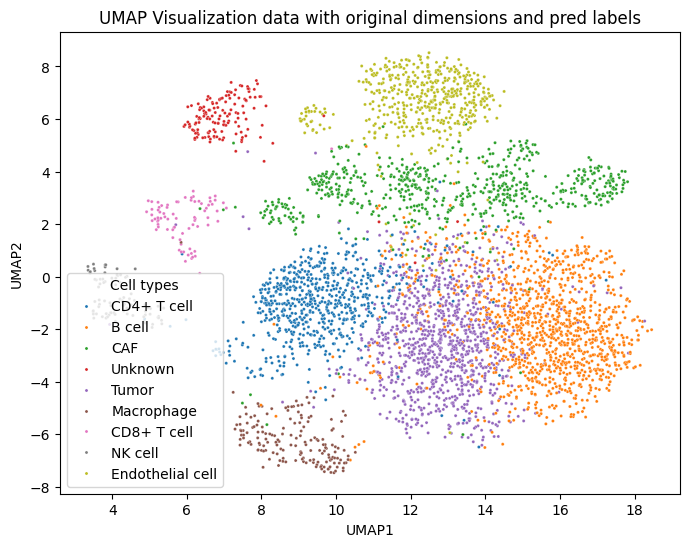

Number of cell types: [0 1 2 3 4 5 6 7 8]
Data dimensions: (4513, 128)
{0: 'B cell', 1: 'CAF', 2: 'CD4+ T cell', 3: 'CD8+ T cell', 4: 'Endothelial cell', 5: 'Macrophage', 6: 'NK cell', 7: 'Tumor', 8: 'Unknown'}
       UMAP1      UMAP2  Label  Cluster   Cell types
0  21.618923  -2.655940      0        0       B cell
1  10.879979   9.713206      3        3  CD8+ T cell
2   2.421060  17.173794      7        7        Tumor
3  -0.020608   6.712611      7        7        Tumor
4  -2.751506  19.529411      7        7        Tumor
{0: 'B cell', 1: 'CAF', 2: 'CD4+ T cell', 3: 'CD8+ T cell', 4: 'Endothelial cell', 5: 'Macrophage', 6: 'NK cell', 7: 'Tumor', 8: 'Unknown'}
       UMAP1      UMAP2  Label  Cluster   Cell types
0  21.618923  -2.655940      2        2  CD4+ T cell
1  10.879979   9.713206      0        0       B cell
2   2.421060  17.173794      1        1          CAF
3  -0.020608   6.712611      8        8      Unknown
4  -2.751506  19.529411      1        1          CAF


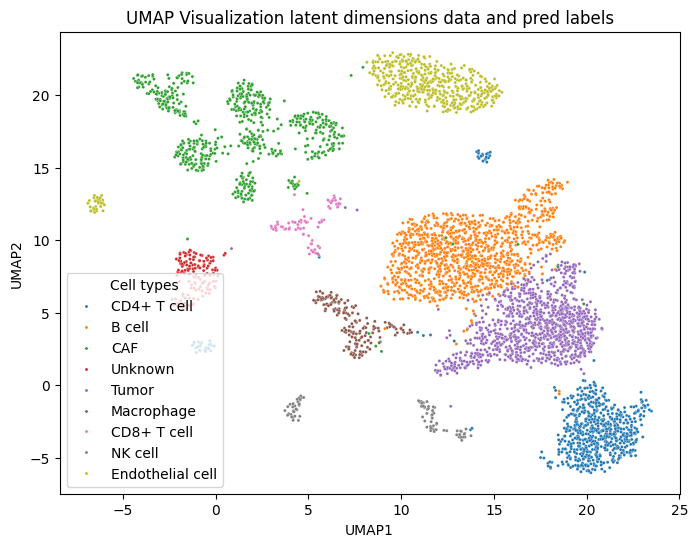

	Evalute: [nmi: 0.734897] [ari: 0.667598] [acc: 0.736317]
[{'nmi': 0.7348966452258777, 'ari': 0.6675980518015926, 'acc': 0.7363173055617106, 'sil': 0.340293, 'dataset': 'Melanoma_5K', 'epoch': 79}]


In [171]:
run_scMAE()